## MNIST CNN

MNIST is a simple computer vision dataset. It consists of images of handwritten digits like these:

<img src="files/images/MNIST.png">

It also includes labels for each image, telling us which digit it is. For example, the labels for the above images are 5, 0, 4, and 1.

The MNIST data is hosted on Yann LeCun's website. But we can easily get at it via Keras:

In [1]:
import tensorflow as tf
from tensorflow import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

/Users/hen/anaconda/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers import Dropout

import pydot
from IPython.display import SVG
from tensorflow.python.keras._impl.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras._impl.keras import backend as K

In [3]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

The next thing that we want to do is to normalize the input data. We do this in two ways. First we add a channel and second we reduce the variance in the xs by pushing the inputs between 1 and 0

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Now let's make a CNN

Getting 93% accuracy on MNIST is bad. It's almost embarrassingly bad. In this section, we'll fix that, jumping from a very simple model to something moderately sophisticated: a small convolutional neural network. This will get us to around 99.2% accuracy -- not state of the art, but respectable.

#### Convolutions and Pooling

TensorFlow also gives us a lot of flexibility in convolution and pooling operations. How do we handle the boundaries? What is our stride size? In this example, we're always going to choose the vanilla version. Our convolutions uses a stride of one and are zero padded so that the output is the same size as the input. Our pooling is plain old max pooling over 2x2 blocks.

#### First Convolutional Layer

We can now implement our first layer. It will consist of convolution, followed by max pooling. The convolution will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.

To apply the layer, we first reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels.

In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

#### Second Conv Layer

Somewhat typical of deep networks we increase the number of filters/features as we go deeper. So we increase to 64.

In [6]:
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#### Dropout

To reduce overfitting, we will apply dropout before the readout layer. Keras automatically takes care of testing vs training, and turns it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.


In [7]:
model.add(Dropout(0.25))
model.add(Flatten())

#### Densely Connected Layer

Now that the image size has been reduced to 7x7, we add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [8]:
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

#### Readout Layer

Finally, we add a layer, just like for the one layer softmax regression above.

In [9]:
model.add(Dense(num_classes, activation='softmax'))

## Training our Model

How well does this model do? To train and evaluate it we will use code that is nearly identical to that for the simple one layer SoftMax network above.

We will change the adam optimizer slightly. But that is all.

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [11]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adadelta', 
    metrics=['accuracy'])

model.fit(
    x_train, 
    y_train, 
    epochs=12, 
    batch_size=50, 
    validation_split=0.1,
    # ignore this line for now
    callbacks=[TensorBoard(histogram_freq=1, log_dir='mnist_cnn_logs')],
    verbose=2)


Train on 54000 samples, validate on 6000 samples
Epoch 1/12
159s - loss: 0.2552 - acc: 0.9244 - val_loss: 0.0712 - val_acc: 0.9790
Epoch 2/12
1879s - loss: 0.1040 - acc: 0.9692 - val_loss: 0.0485 - val_acc: 0.9870
Epoch 3/12
161s - loss: 0.0808 - acc: 0.9757 - val_loss: 0.0437 - val_acc: 0.9892
Epoch 4/12
162s - loss: 0.0673 - acc: 0.9792 - val_loss: 0.0413 - val_acc: 0.9892
Epoch 5/12
164s - loss: 0.0601 - acc: 0.9816 - val_loss: 0.0369 - val_acc: 0.9900
Epoch 6/12
160s - loss: 0.0546 - acc: 0.9836 - val_loss: 0.0362 - val_acc: 0.9908
Epoch 7/12
161s - loss: 0.0516 - acc: 0.9847 - val_loss: 0.0378 - val_acc: 0.9902
Epoch 8/12
164s - loss: 0.0483 - acc: 0.9855 - val_loss: 0.0376 - val_acc: 0.9888
Epoch 9/12
163s - loss: 0.0467 - acc: 0.9863 - val_loss: 0.0349 - val_acc: 0.9900
Epoch 10/12
162s - loss: 0.0460 - acc: 0.9862 - val_loss: 0.0358 - val_acc: 0.9898
Epoch 11/12
159s - loss: 0.0434 - acc: 0.9874 - val_loss: 0.0370 - val_acc: 0.9902
Epoch 12/12
159s - loss: 0.0439 - acc: 0.9872 

In [12]:
model.save('models/mnist_conv.h5')

In [13]:
model = load_model('models/mnist_conv.h5')

## Visualizations

First let's have a bit of fun, then let's dive into Tensorboard, our key visualization library. 

#### Visualizing the kernels

Below we visualize the kernels of the first layers. Can you visualize the kernels of the second layer?

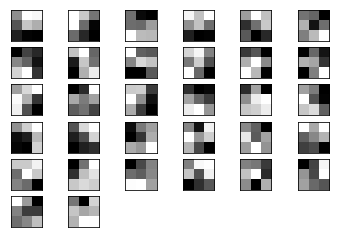

In [14]:
W = model.layers[0].get_weights()[0]

for i in range(32):
    plt.subplot(6, 6, i+1)
    weight = W[:, :, 0, i]
    plt.imshow(weight, cmap='gray')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

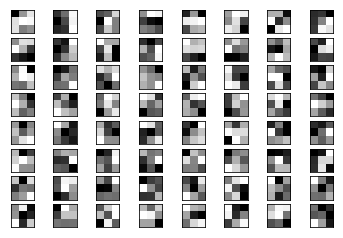

In [15]:
W = model.layers[1].get_weights()[0]

for i in range(64):
    plt.subplot(8, 8, i+1)
    weight = W[:, :, 0, i]
    plt.imshow(weight, cmap='gray')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

#### Vis the Activations

Next up is the activations

In [16]:
first_conv = model.layers[0]

first_conv_activation_fxn = K.function([model.input], [first_conv.output])

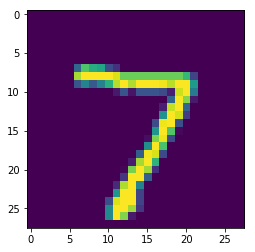

In [17]:
plt.imshow(x_test[0][:, :, 0])

In [18]:
first_conv_activation = first_conv_activation_fxn([[x_test[0]]])

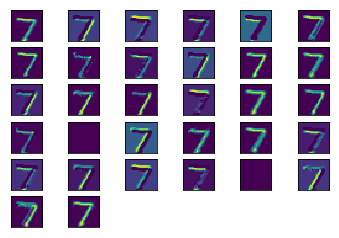

In [19]:
for i in range(32):
    plt.subplot(6, 6, i+1)
    act = first_conv_activation[0][0, :, :, i]
    plt.imshow(act)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

In [20]:
second_conv = model.layers[1]

second_conv_activation_fxn = K.function([model.input], [second_conv.output])

In [21]:
second_conv_activation = second_conv_activation_fxn([[x_test[0]]])


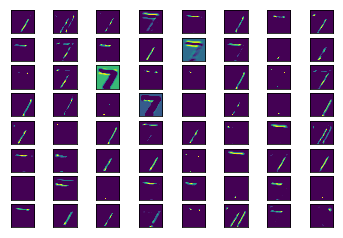

In [22]:
for i in range(64):
    plt.subplot(8, 8, i+1)
    act = second_conv_activation[0][0, :, :, i]
    plt.imshow(act)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

## Tensorboard

While this looks nice, there is a much better tool that we can use to visualize all this stuff, and it is called tensorboard.

The computations you'll use TensorFlow for - like training a massive deep neural network - can be complex and confusing. To make it easier to understand, debug, and optimize TensorFlow programs, we've included a suite of visualization tools called TensorBoard. You can use TensorBoard to visualize your TensorFlow graph, plot quantitative metrics about the execution of your graph, and show additional data like images that pass through it. When TensorBoard is fully configured, it looks like this:

<img src="files/images/mnist_tensorboard.png">

The nice thing is that we have been pumping data into tensorboard from the very beginning, so let's check it out!



# Model Vivisection 

Let's have some fun. We have played with convolutions so there are a couple of things we can do. We can play with model parameters, but with a model this big we should probably train on the cloud, so instead let's check out visualization.

1. Find an example that was incorrectly clsssified
2. Visualize the first and second activations of that digit. Does it make sense why it was misclassified



Check below for embeddings

https://github.com/fchollet/keras/pull/5247